In [1]:
import pandas as pd
#import stockstats as StockDataFrame
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from ipywidgets import *
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.rc("figure", figsize=(9, 7))
sns.set_style('whitegrid')

%matplotlib inline
pd.set_option('display.max_columns', 500)
from sklearn.metrics import f1_score
from scipy.optimize import least_squares
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

/home/matthew/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load stock data

In [2]:
df = pd.read_csv('toram.csv')

In [3]:
def middle_of_month(name):
    name['date'] = pd.DatetimeIndex(name['date'])
    stockmiddle = name.loc[:,('date','open')]
    stockmiddle['date'] = pd.DatetimeIndex(stockmiddle['date']) + pd.DateOffset(-14)
    stockmiddle['14 day price'] = stockmiddle['open']
    stockmiddle.set_index('date', drop=False, inplace=True)
    stockmiddle.drop('open', 1, inplace=True)
    stock30 = name.loc[:,('date','open')]
    stock30['date'] = pd.DatetimeIndex(stock30['date']) + pd.DateOffset(-28)
    stock30['28 day price'] = stock30['open']
    stock30.set_index('date', drop=False, inplace=True)
    stock30.drop('open', 1, inplace=True)
    stock60 = name.loc[:,('date','open')]
    stock60['date'] = pd.DatetimeIndex(stock60['date']) + pd.DateOffset(-63)
    stock60['63 day price'] = stock60['open']
    stock60.set_index('date', drop=False, inplace=True)
    stock60.drop('open', 1, inplace=True)
    name.set_index('date', drop=False, inplace=True)
    output = pd.merge(name,stockmiddle, left_on='date', right_on='date')
    output = pd.merge(output,stock30, left_on='date', right_on='date')
    output = pd.merge(output,stock60, left_on='date', right_on='date')
    output['2 week gain'] = (output['14 day price'] / output['open']) - 1
    output['4 week gain'] = (output['28 day price'] / output['open']) - 1
    output['9 week gain'] = (output['63 day price'] / output['open']) - 1
    output.set_index('date', drop=False, inplace=True)
    return output

In [4]:
def derivative(data):
    data = data.iloc[1:]
    data['Category: All categories'] = data['Category: All categories'].astype(float)
    data['derivative'] = data['Category: All categories'].diff(periods = 1)
    data.index = [datetime.strptime(date, '%Y-%m-%d').date() for date in data.index]
    data.index = data.index + pd.DateOffset(-2)
    return data
    
def stock(stock,datastock):
    stockdata = df[df['ticker'] == str(stock)]
    datastock = middle_of_month(stockdata)
    return datastock
    
def mergefunction(stock,derivative):
    stock = stock.iloc[1:]
    derivative = pd.merge(stock, derivative,
                          left_index = True,
                          right_index = True,
                          how='inner')
    return stock

In [5]:
darden = pd.read_csv('trendsjohnson2.csv')
darden = derivative(darden)
teststock = df[df['ticker'] == 'JNJ']
dardenstock = middle_of_month(teststock)
#darden = darden.iloc[1:]
johnson = pd.merge(dardenstock, darden,
                    left_index = True,
                    right_index = True,
                    how='inner')
johnson.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-22,2012-06-22,JNJ,66.66,66.970,66.520,66.63,18965700.0,0.0,1.0,58.034485,58.304372,57.912600,58.008367,18965700.0,1.264254e+09,1.263685e+09,-568971.0,0.006742,-0.03,-0.000450,65.385195,64.553570,0.831625,0.390400,0.882449,-5579600.0,-0.179695,66.56,0.10,66.706667,153.295748,141.402398,115.618912,67.51,69.35,67.22,0.012751,0.040354,0.008401,50.0,NaN
2012-06-29,2012-06-29,JNJ,67.30,67.700,67.215,67.56,18286000.0,0.0,1.0,58.591672,58.939913,58.517670,58.818029,18286000.0,1.230648e+09,1.235402e+09,4754360.0,0.007190,0.26,0.003863,66.266795,65.300877,0.965918,0.739982,0.451871,6175100.0,1.324902,67.96,-0.66,67.491667,178.314774,157.653716,149.052420,67.79,68.95,67.45,0.007281,0.024517,0.002229,50.0,0.0
2012-07-06,2012-07-06,JNJ,67.51,67.875,67.360,67.64,9758000.0,0.0,1.0,58.774499,59.092269,58.643908,58.887677,9758000.0,6.587626e+08,6.600311e+08,1268540.0,0.007616,0.13,0.001926,67.031903,65.976849,1.055055,0.930025,0.250059,-2099800.0,-0.662154,67.97,-0.46,67.625000,225.548436,208.162110,167.722571,69.35,68.98,67.97,0.027255,0.021775,0.006814,53.0,3.0
2012-07-13,2012-07-13,JNJ,67.79,68.740,67.730,68.61,13238800.0,0.0,1.0,59.018268,59.845342,58.966032,59.732163,13238800.0,8.974583e+08,9.083141e+08,10855816.0,0.014802,0.82,0.012096,67.596626,66.622987,0.973639,0.967623,0.012032,-3245400.0,-0.352786,67.84,-0.05,68.360000,255.337488,243.228196,229.839544,68.95,68.12,68.91,0.017112,0.004868,0.016522,53.0,0.0
2012-07-20,2012-07-20,JNJ,69.35,69.360,68.350,68.63,13964600.0,0.0,1.0,60.376411,60.385117,59.505806,59.749575,13964600.0,9.684450e+08,9.583905e+08,-10054512.0,0.014669,-0.72,-0.010382,68.400727,67.384740,1.015987,1.007046,0.017882,465100.0,0.887402,68.10,1.25,68.780000,212.667059,256.927111,244.999587,68.98,68.12,69.05,-0.005335,-0.017736,-0.004326,50.0,-3.0


In [6]:
dominos = pd.read_csv('trendspfizer.csv')
dominos = derivative(dominos)
teststock = df[df['ticker'] == 'PFE']
dominostock = middle_of_month(teststock)
dominos = dominos.iloc[1:]
pfizer = pd.merge(dominostock, dominos,
                    left_index = True,
                    right_index = True,
                    how='inner')
pfizer.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,PFE,22.83,23.00,22.71,23.000,32583200.0,0.0,1.0,19.143737,19.286288,19.043113,19.286288,32583200.0,7.438745e+08,7.494136e+08,5539144.0,0.012689,0.170,0.007446,22.571615,22.443916,0.127699,0.081124,0.093149,9566600.0,1.737968,22.94,-0.11,22.903333,132.759363,107.715683,106.103823,22.71,23.67,23.88,-0.005256,0.036794,0.045992,48.0,-4.0
2012-07-06,2012-07-06,PFE,22.57,22.60,22.37,22.540,18983800.0,0.0,1.0,18.925718,18.950874,18.758011,18.900562,18983800.0,4.284644e+08,4.278949e+08,-569514.0,0.010229,-0.030,-0.001329,22.651887,22.526004,0.125883,0.117945,0.015876,-5575200.0,-1.612903,22.72,-0.15,22.503333,113.974663,127.576771,117.895290,23.69,24.10,24.31,0.049623,0.067789,0.077093,50.0,2.0
2012-07-13,2012-07-13,PFE,22.71,22.90,22.70,22.810,28156800.0,0.0,1.0,19.043113,19.202434,19.034727,19.126966,28156800.0,6.394409e+08,6.422566e+08,2815680.0,0.008772,0.100,0.004403,22.624318,22.546799,0.077519,0.091292,-0.027545,-15073600.0,1.429209,23.15,-0.44,22.803333,137.047939,130.494274,123.759728,23.67,23.86,24.18,0.042272,0.050638,0.064729,53.0,3.0
2012-07-20,2012-07-20,PFE,23.69,23.87,23.63,23.700,112295700.0,0.0,1.0,19.864876,20.015812,19.814564,19.873262,112295700.0,2.660285e+09,2.661408e+09,1122957.0,0.010105,0.010,0.000422,23.190068,22.884022,0.306046,0.192437,0.227218,5072200.0,0.679983,23.40,0.29,23.733333,154.549412,151.572981,137.123630,24.10,24.07,24.46,0.017307,0.016041,0.032503,50.0,-3.0
2012-07-27,2012-07-27,PFE,23.67,23.94,23.51,23.825,34561000.0,0.0,1.0,19.848105,20.074510,19.713940,19.978078,34561000.0,8.180589e+08,8.234158e+08,5356955.0,0.018124,0.155,0.006548,23.391123,23.091119,0.300003,0.261120,0.077767,9062900.0,1.197093,23.91,-0.24,23.758333,127.723881,119.521999,142.417174,23.86,23.72,25.00,0.008027,0.002112,0.056189,49.0,-1.0


In [7]:
racism = pd.read_csv('trendsmerck.csv')
racism = derivative(racism)
teststock = df[df['ticker'] == 'MRK']
raciststock = middle_of_month(teststock)
racism = racism.iloc[1:]
merck = pd.merge(raciststock, racism,
                    left_index = True,
                    right_index = True,
                    how='inner')
merck.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,MRK,40.89,41.75,40.89,41.750,23675500.0,0.0,1.0,34.917228,35.651608,34.917228,35.651608,23675500.0,9.680912e+08,9.884521e+08,20360930.0,0.020813,0.860,0.021032,39.966165,39.233481,0.732684,0.470121,0.525125,11113000.0,2.020958,41.73,-0.84,41.463333,274.536804,205.941449,157.301475,43.06,43.75,43.33,0.053069,0.069944,0.059672,81.0,-7.0
2012-07-06,2012-07-06,MRK,41.33,41.55,41.29,41.510,10060600.0,0.0,1.0,35.292957,35.480822,35.258800,35.446665,10060600.0,4.158046e+08,4.176155e+08,1810908.0,0.006277,0.180,0.004355,40.798952,39.883966,0.914986,0.721025,0.387922,809200.0,-0.958543,42.18,-0.85,41.450000,241.504065,257.639281,228.182620,43.62,44.44,44.43,0.055408,0.075248,0.075006,92.0,11.0
2012-07-13,2012-07-13,MRK,43.06,43.57,42.93,43.470,16968500.0,0.0,1.0,36.770257,37.205762,36.659246,37.120369,16968500.0,7.306636e+08,7.376207e+08,6957085.0,0.014798,0.410,0.009522,41.688167,40.651028,1.037139,0.874990,0.324297,-28986600.0,4.059932,43.29,-0.23,43.323333,274.015748,258.825428,254.679037,43.75,43.98,44.55,0.016024,0.021366,0.034603,82.0,-10.0
2012-07-20,2012-07-20,MRK,43.62,43.66,43.31,43.410,13016800.0,0.0,1.0,37.248459,37.282616,36.983740,37.069133,13016800.0,5.677928e+08,5.650593e+08,-2733528.0,0.008049,-0.210,-0.004814,42.858484,41.644899,1.213585,1.099677,0.227815,-973300.0,-0.705668,43.22,0.40,43.460000,223.241496,238.645924,254.587969,44.44,44.04,44.95,0.018799,0.009629,0.030491,86.0,4.0
2012-07-27,2012-07-27,MRK,43.75,45.17,43.46,45.095,29980900.0,0.0,1.0,37.359470,38.572051,37.111830,38.508006,29980900.0,1.311664e+09,1.351989e+09,40324310.5,0.038587,1.345,0.030743,43.254426,42.227899,1.026526,1.037557,-0.022060,13677600.0,1.957586,44.45,-0.70,44.575000,204.840125,184.286408,213.336145,43.98,42.64,45.05,0.005257,-0.025371,0.029714,79.0,-7.0


In [8]:
texas = pd.read_csv('trendsunitedhealth.csv')
texas = derivative(texas)
teststock = df[df['ticker'] == 'UNH']
texasstock = middle_of_month(teststock)
texas = texas.iloc[1:]
unitedhealth = pd.merge(texasstock, texas,
                    left_index = True,
                    right_index = True,
                    how='inner')
unitedhealth.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,UNH,60.34,60.60,57.870,58.50,11121700.0,0.0,1.0,55.865791,56.106512,53.578941,54.162226,11121700.0,671083378.0,650619450.0,-20463928.0,0.046088,-1.84,-0.030494,58.703978,58.033940,0.670038,0.700955,-0.061834,-14198200.0,1.411765,56.39,3.95,58.990000,126.878677,131.113883,143.012340,54.61,51.81,54.84,-0.094962,-0.141366,-0.091150,52.0,-11.0
2012-07-06,2012-07-06,UNH,55.29,55.94,55.150,55.82,4458600.0,0.0,1.0,51.190248,51.792050,51.060629,51.680948,4458600.0,246515994.0,248879052.0,2363058.0,0.014223,0.53,0.009586,57.234558,57.412803,-0.178245,0.302487,-0.961466,-2479200.0,-1.950700,56.27,-0.98,55.636667,91.730490,100.941895,125.640723,54.87,51.38,54.97,-0.007596,-0.070718,-0.005788,63.0,11.0
2012-07-13,2012-07-13,UNH,54.61,55.55,54.570,55.20,5053000.0,0.0,1.0,50.560670,51.430969,50.523636,51.106921,5053000.0,275944330.0,278925600.0,2981270.0,0.017799,0.59,0.010804,56.209810,56.793991,-0.584181,-0.207855,-0.752651,-1026200.0,-2.079971,55.21,-0.60,55.106667,84.609808,95.469570,94.341290,51.81,51.84,54.70,-0.051273,-0.050723,0.001648,62.0,-1.0
2012-07-20,2012-07-20,UNH,54.87,55.83,54.860,55.41,8367300.0,0.0,1.0,50.801391,51.690207,50.792132,51.301350,8367300.0,459113751.0,463632093.0,4518342.0,0.017526,0.54,0.009841,55.831744,56.398012,-0.566268,-0.450591,-0.231354,-8329300.0,-1.206338,54.64,0.23,55.366667,80.111486,81.699878,88.612642,51.38,53.64,55.09,-0.063605,-0.022417,0.004009,60.0,-2.0
2012-07-27,2012-07-27,UNH,51.81,53.51,51.694,53.34,8569900.0,0.0,1.0,47.968290,49.542235,47.860891,49.384840,8569900.0,444006519.0,457118466.0,13111947.0,0.034523,1.53,0.029531,54.390617,55.430830,-1.040213,-0.742576,-0.595274,-1940700.0,0.601942,52.74,-0.93,52.848000,62.626545,64.186676,77.230560,51.84,53.87,55.95,0.000579,0.039761,0.079907,59.0,-1.0


In [9]:
jack = pd.read_csv('trendsamgen.csv')
jack = derivative(jack)
teststock = df[df['ticker'] == 'AMGN']
jackstock = middle_of_month(teststock)
jack = jack.iloc[1:]
amgen = pd.merge(jackstock, jack,
                    left_index = True,
                    right_index = True,
                    how='inner')
amgen.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,AMGN,72.73,73.04,72.1101,72.91,4918700.0,0.0,1.0,65.407747,65.686537,64.850257,65.569625,4918700.0,357737051.0,3.586224e+08,885366.0,0.012813,0.18,0.002475,71.614776,70.826750,0.788026,0.649114,0.277825,443000.0,1.238864,74.04,-1.31,72.686700,146.626449,127.637883,118.813705,75.76,80.51,83.81,0.041661,0.106971,0.152344,18.0,-4.0
2012-07-06,2012-07-06,AMGN,74.27,74.62,73.7400,73.85,3103100.0,0.0,1.0,66.792704,67.107467,66.316063,66.414989,3103100.0,230467237.0,2.291639e+08,-1303302.0,0.011863,-0.42,-0.005655,72.958491,71.773926,1.184565,0.934420,0.500290,-127800.0,0.310643,74.85,-0.58,74.070000,146.524503,153.704754,137.892943,79.62,82.54,85.00,0.072034,0.111350,0.144473,21.0,3.0
2012-07-13,2012-07-13,AMGN,75.76,77.00,75.7400,76.96,3234900.0,0.0,1.0,68.132695,69.247855,68.114709,69.211883,3234900.0,245076024.0,2.489579e+08,3881880.0,0.016499,1.20,0.015839,74.619229,73.059345,1.559884,1.262058,0.595652,-1582900.0,1.310511,77.62,-1.86,76.566667,181.920047,177.392686,159.508773,80.51,81.93,83.59,0.062698,0.081441,0.103353,22.0,1.0
2012-07-20,2012-07-20,AMGN,79.62,79.62,77.5600,77.77,6772300.0,0.0,1.0,71.604081,71.604081,69.751476,69.940334,6772300.0,539210526.0,5.266818e+08,-12528755.0,0.026212,-1.85,-0.023235,76.902335,74.840129,2.062206,1.749275,0.625862,1877500.0,1.310599,77.91,1.71,78.316667,215.515909,231.117495,192.657917,82.54,83.46,82.47,0.036674,0.048229,0.035795,23.0,1.0
2012-07-27,2012-07-27,AMGN,80.51,83.98,80.4800,83.92,12360300.0,0.0,1.0,72.404478,75.525129,72.377499,75.471169,12360300.0,995127753.0,1.037276e+09,42148623.0,0.042564,3.41,0.042355,78.410300,76.253099,2.157201,1.848799,0.616802,6492500.0,3.496593,83.13,-2.62,82.793333,187.257738,164.035293,212.685664,81.93,83.49,83.99,0.017638,0.037014,0.043224,20.0,-3.0


In [10]:
daveandbusters = pd.read_csv('trendsmedtronic.csv')
daveandbusters = derivative(daveandbusters)
teststock = df[df['ticker'] == 'PLAY']
davestock = middle_of_month(teststock)
dave = daveandbusters.iloc[1:]
medtronic = pd.merge(davestock, dave,
                    left_index = True,
                    right_index = True,
                    how='inner')
medtronic.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,date,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative


In [11]:
gobble = pd.read_csv('trendsabbvie.csv')
gobble = derivative(gobble)
teststock = df[df['ticker'] == 'ABBV']
gobblestock = middle_of_month(teststock)
gobble = gobble.iloc[1:]
abbvie = pd.merge(gobblestock, gobble,
                    left_index = True,
                    right_index = True,
                    how='inner')
abbvie.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2013-01-04,2013-01-04,ABBV,34.62,34.89,34.250,34.3908,21372100.0,0.0,1.0,29.419255,29.648694,29.104838,29.224486,21372100.0,739902102.0,7.350036e+08,-4898485.32,0.018513,-0.2292,-0.006620,42.520945,45.066991,-2.546046,-1.033496,-3.025100,4632800.0,-0.859107,34.29,0.33,34.510267,49.399822,71.607581,98.088719,36.43,36.84,37.64,0.052282,0.064125,0.087233,44.0,-37.0
2013-01-11,2013-01-11,ABBV,33.59,33.90,33.350,33.8500,11191500.0,0.4,1.0,28.881285,29.147828,28.674929,29.104838,11191500.0,375922485.0,3.788323e+08,2909790.00,0.016357,0.2600,0.007740,37.671178,41.522539,-3.851361,-2.768648,-2.165427,-4466600.0,-0.059506,33.71,-0.12,33.700000,40.711065,44.131414,50.387335,37.52,36.37,37.44,0.116999,0.082763,0.114617,33.0,-11.0
2013-01-18,2013-01-18,ABBV,36.43,37.32,36.040,37.3200,17842200.0,0.0,1.0,31.323168,32.088406,30.987839,32.088406,17842200.0,649991346.0,6.658709e+08,15879558.00,0.034896,0.8900,0.024430,36.650850,39.669602,-3.018752,-3.203541,0.369578,3417400.0,5.686104,36.91,-0.48,36.893333,55.007316,52.074865,43.572624,36.84,36.93,38.57,0.011254,0.013725,0.058743,33.0,0.0
2013-02-01,2013-02-01,ABBV,36.84,37.20,36.520,37.1800,9527500.0,0.0,1.0,31.675693,31.985228,31.400551,31.968031,9527500.0,350993100.0,3.542324e+08,3239350.00,0.018448,0.3400,0.009229,37.002998,38.398417,-1.395420,-1.947370,1.103901,-1193200.0,0.081500,37.42,-0.58,36.966667,52.311312,51.629519,54.178781,36.93,36.80,41.31,0.002443,-0.001086,0.121336,30.0,0.0
2013-02-08,2013-02-08,ABBV,36.37,36.42,35.825,36.2500,13858700.0,0.0,1.0,31.271579,31.314570,30.802978,31.168401,13858700.0,504040919.0,5.023779e+08,-1663044.00,0.016472,-0.1200,-0.003299,36.866557,37.892300,-1.025743,-1.370835,0.690184,3986200.0,-1.596320,35.77,0.60,36.165000,103.148948,64.973970,54.213425,38.79,37.64,42.97,0.066538,0.034919,0.181468,30.0,0.0


In [12]:
buffalo8 = pd.read_csv('trendsbristolmyerssquibb.csv')
buffalo8 = derivative(buffalo8)
teststock = df[df['ticker'] == 'BMY']
buffalo8stock = middle_of_month(teststock)
buffalo8 = buffalo8.iloc[1:]
bristol = pd.merge(buffalo8stock, buffalo8,
                    left_index = True,
                    right_index = True,
                    how='inner')
bristol.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,BMY,35.30,35.95,35.30,35.95,11189900.0,0.0,1.0,30.577079,31.140113,30.577079,31.140113,11189900.0,395003470.0,402276905.0,7273435.0,0.018246,0.65,0.018414,34.849657,34.387226,0.462430,0.380155,0.164551,-979500.0,1.262192,35.51,-0.21,35.733333,202.279625,166.924289,158.904394,35.00,35.99,32.90,-0.008499,0.019547,-0.067989,89.0,4.0
2012-07-06,2012-07-06,BMY,34.45,34.85,34.37,34.61,7690000.0,0.0,1.0,30.131433,30.481290,30.061462,30.271376,7690000.0,264920500.0,266150900.0,1230400.0,0.013869,0.16,0.004644,34.920941,34.560956,0.359985,0.409456,-0.098942,-164400.0,-2.985075,35.10,-0.65,34.610000,128.056345,166.361103,181.145528,36.06,32.96,33.48,0.046734,-0.043251,-0.028157,85.0,-4.0
2012-07-13,2012-07-13,BMY,35.00,35.50,34.96,35.37,8481600.0,0.0,1.0,30.612487,31.049808,30.577501,30.936104,8481600.0,296856000.0,299994192.0,3138192.0,0.015328,0.37,0.010571,34.941233,34.681015,0.260218,0.314941,-0.109446,-1260300.0,0.574713,35.49,-0.49,35.276667,131.579308,131.786820,140.176103,35.99,31.78,33.68,0.028286,-0.092000,-0.037714,80.0,-5.0
2012-07-20,2012-07-20,BMY,36.06,36.06,35.39,35.42,10395500.0,0.0,1.0,31.539608,31.539608,30.953597,30.979836,10395500.0,374861730.0,368208610.0,-6653120.0,0.018754,-0.64,-0.017748,35.434145,35.043151,0.390993,0.355816,0.070356,3085300.0,0.445682,35.00,1.06,35.623333,132.232422,138.757062,129.881014,32.96,32.02,33.17,-0.085968,-0.112035,-0.080144,82.0,2.0
2012-07-27,2012-07-27,BMY,35.99,36.18,35.94,36.05,15218900.0,0.0,1.0,31.478383,31.644565,31.434650,31.530861,15218900.0,547728211.0,548641345.0,913134.0,0.006656,0.06,0.001667,35.420955,35.141330,0.279625,0.289325,-0.019399,5911900.0,3.389831,35.69,0.30,36.056667,130.329741,114.633742,128.443903,31.78,32.28,33.78,-0.116977,-0.103084,-0.061406,94.0,12.0


In [13]:
walmart = pd.read_csv('trends_eli_lilly.csv')
walmart = derivative(walmart)
teststock = df[df['ticker'] == 'LLY']
walmartstock = middle_of_month(teststock)
walmart = walmart.iloc[1:]
elililly = pd.merge(walmartstock, walmart,
                    left_index = True,
                    right_index = True,
                    how='inner')
elililly.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,LLY,42.52,42.91,42.46,42.91,6136800.0,0.0,1.0,36.365013,36.698559,36.313699,36.698559,6136800.0,260936736.0,263330088.0,2393352.0,0.010542,0.39,0.009172,41.956141,41.621503,0.334638,0.280543,0.108189,1061800.0,2.113353,42.95,-0.43,42.760000,158.507308,138.587276,136.303026,42.92,44.00,45.07,0.009407,0.034807,0.059972,78.0,-8.0
2012-07-06,2012-07-06,LLY,42.70,42.74,42.42,42.66,3244300.0,0.0,1.0,36.518957,36.553167,36.279489,36.484748,3244300.0,138531610.0,138401838.0,-129772.0,0.007515,-0.04,-0.000937,42.409752,41.960863,0.448889,0.375519,0.146739,-515900.0,-0.582072,43.08,-0.38,42.606667,131.261535,146.210098,144.440472,44.16,43.97,46.71,0.034192,0.029742,0.093911,85.0,7.0
2012-07-13,2012-07-13,LLY,42.92,43.50,42.73,43.26,4580100.0,0.0,1.0,36.707111,37.203153,36.544615,36.997895,4580100.0,196577892.0,198135126.0,1557234.0,0.017859,0.34,0.007922,42.724126,42.277410,0.446715,0.421301,0.050829,504500.0,0.609470,44.08,-1.16,43.163333,163.970363,162.952430,146.154064,44.00,42.74,47.01,0.025163,-0.004194,0.095294,78.0,-7.0
2012-07-20,2012-07-20,LLY,44.16,44.27,43.98,44.17,6506800.0,0.0,1.0,37.767615,37.861692,37.613671,37.776167,6506800.0,287340288.0,287405356.0,65068.0,0.006572,0.01,0.000226,43.565424,42.889531,0.675893,0.557922,0.235941,1914700.0,0.706956,42.74,1.42,44.140000,170.948522,175.223939,167.264194,43.97,42.85,47.17,-0.004303,-0.029665,0.068161,80.0,2.0
2012-07-27,2012-07-27,LLY,44.00,44.53,43.99,44.37,7526500.0,0.0,1.0,37.630776,38.084056,37.622223,37.947216,7526500.0,331166000.0,333950805.0,2784805.0,0.012201,0.37,0.008409,43.519042,43.060969,0.458073,0.493989,-0.071833,560100.0,1.687081,44.08,-0.08,44.296667,147.595530,129.196501,157.471772,42.74,44.81,47.37,-0.028636,0.018409,0.076591,78.0,-2.0


In [14]:
costco = pd.read_csv('trendsgilead.csv')
costco = derivative(costco)
teststock = df[df['ticker'] == 'GILD']
costcostock = middle_of_month(teststock)
costco = costco.iloc[1:]
gilead = pd.merge(costcostock, costco,
                    left_index = True,
                    right_index = True,
                    how='inner')
gilead.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,GILD,51.14,51.36,50.43,51.28,5417800.0,0.0,1.0,24.515016,24.620477,24.174662,24.582127,10835600.0,277066292.0,277824784.0,758492.0,0.018273,0.14,0.002738,50.446965,50.244617,0.202348,0.086306,0.232085,233800.0,1.548848,51.53,-0.39,51.023333,115.015432,104.047389,90.859440,50.55,53.96,57.68,-0.011537,0.055143,0.127884,22.0,0.0
2012-07-06,2012-07-06,GILD,51.47,51.73,50.76,50.96,3282900.0,0.0,1.0,24.673208,24.797844,24.332855,24.428729,6565800.0,168970863.0,167296584.0,-1674279.0,0.018929,-0.51,-0.009909,50.948377,50.579284,0.369092,0.249895,0.238393,96600.0,-0.116437,51.91,-0.44,51.150000,111.814571,115.292871,108.279250,53.68,57.88,59.60,0.042938,0.124539,0.157956,25.0,3.0
2012-07-13,2012-07-13,GILD,50.55,51.26,50.51,51.17,3590800.0,0.0,1.0,24.232187,24.572540,24.213012,24.529397,7181600.0,181514940.0,183741236.0,2226296.0,0.014739,0.62,0.012265,51.018507,50.744489,0.274018,0.297470,-0.046903,-1404000.0,0.297619,52.49,-1.94,50.980000,132.502525,132.919850,124.033592,53.96,56.88,60.17,0.067458,0.125223,0.190307,55.0,30.0
2012-07-20,2012-07-20,GILD,53.68,54.00,53.03,53.08,6206200.0,0.0,1.0,25.732617,25.886016,25.421026,25.444995,12412400.0,333148816.0,329425096.0,-3723720.0,0.018126,-0.60,-0.011177,52.168837,51.464805,0.704032,0.485957,0.436150,960400.0,1.551267,51.95,1.73,53.370000,160.217308,152.011212,134.188169,57.88,56.93,67.35,0.078241,0.060544,0.254657,29.0,-26.0
2012-07-27,2012-07-27,GILD,53.96,55.59,53.62,55.50,14055300.0,0.0,1.0,25.866841,26.648215,25.703855,26.605072,28110600.0,758423988.0,780069150.0,21645162.0,0.036077,1.54,0.028540,52.388258,51.762715,0.625543,0.496097,0.258892,8634700.0,5.370045,54.86,-0.90,54.903333,144.621239,123.856084,145.786336,56.88,56.28,66.47,0.054114,0.042995,0.231838,27.0,-2.0


In [15]:
target = pd.read_csv('trendscvs.csv')
target = derivative(target)
teststock = df[df['ticker'] == 'CVS']
targetstock = middle_of_month(teststock)
target = target.iloc[1:]
cvs = pd.merge(targetstock, target,
                    left_index = True,
                    right_index = True,
                    how='inner')
cvs.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,CVS,46.57,46.93,46.32,46.73,7610300.0,0.0,1.0,42.936065,43.267974,42.705573,43.083580,7610300.0,354411671.0,355629319.0,1217648.0,0.013083,0.16,0.003436,45.782270,45.455789,0.326481,0.237977,0.177008,1714500.0,2.149594,47.64,-1.07,46.660000,128.333824,112.423896,110.416657,47.61,44.83,45.41,0.022332,-0.037363,-0.024909,56.0,-1.0
2012-07-06,2012-07-06,CVS,47.82,48.28,47.70,48.12,5727000.0,0.0,1.0,44.088526,44.512631,43.977890,44.365116,5727000.0,273865140.0,275583240.0,1718100.0,0.012086,0.30,0.006274,46.859489,46.124394,0.735096,0.471226,0.527739,-500100.0,0.377834,47.36,0.46,48.033333,140.173059,136.163855,118.217109,45.26,45.55,46.48,-0.053534,-0.047470,-0.028022,58.0,2.0
2012-07-13,2012-07-13,CVS,47.61,48.20,47.45,48.05,5317800.0,0.0,1.0,43.894912,44.438874,43.747397,44.300578,5317800.0,253180458.0,255520290.0,2339832.0,0.015682,0.44,0.009242,47.173615,46.522843,0.650772,0.587373,0.126797,-4470900.0,1.039898,48.31,-0.70,47.900000,159.980043,150.560860,139.503443,44.83,44.84,47.62,-0.058391,-0.058181,0.000210,57.0,-1.0
2012-07-20,2012-07-20,CVS,45.26,45.50,44.59,45.08,12926600.0,0.0,1.0,41.877546,42.099610,41.257618,41.710998,12926600.0,585057916.0,582731128.0,-2326788.0,0.020202,-0.18,-0.003977,46.971484,46.670530,0.300955,0.559958,-0.518007,-23007400.0,-6.196891,44.83,0.43,45.056667,95.797558,137.764244,159.251222,45.55,44.93,48.10,0.006407,-0.007291,0.062749,58.0,1.0
2012-07-27,2012-07-27,CVS,44.83,45.21,44.56,44.94,9688500.0,0.0,1.0,41.479682,41.831283,41.229860,41.581461,9688500.0,434335455.0,435401190.0,1065735.0,0.014481,0.11,0.002454,45.684770,46.038645,-0.353875,0.039807,-0.787364,1904300.0,0.403135,45.28,-0.45,44.903333,86.497435,85.072936,107.483611,44.84,45.29,48.12,0.000223,0.010261,0.073388,58.0,0.0


In [16]:
dollargeneral = pd.read_csv('trendsallergan.csv')
dollargeneral = derivative(dollargeneral)
teststock = df[df['ticker'] == 'AGN']
dollargeneralstock = middle_of_month(teststock)
dollargeneral = dollargeneral[1:]
allergan = pd.merge(dollargeneralstock, dollargeneral,
                    left_index = True,
                    right_index = True,
                    how='inner')
allergan.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,AGN,72.87,74.41,72.8700,73.99,1579100.0,0.0,1.0,72.298080,73.825993,72.298080,73.409289,1579100.0,115069017.0,116837609.0,1768592.0,0.020913,1.12,0.015370,71.235617,70.787089,0.448528,0.004408,0.888240,371600.0,3.083887,74.72,-1.85,73.756667,127.223762,115.909059,104.059966,75.09,78.46,82.00,0.030465,0.076712,0.125292,17.0,1.0
2012-07-06,2012-07-06,AGN,75.28,75.51,74.2400,75.01,1227900.0,0.0,1.0,74.689165,74.917360,73.657327,74.421284,1227900.0,92436312.0,92104779.0,-331533.0,0.016962,-0.27,-0.003587,73.173147,71.957991,1.215157,0.616758,1.196798,-209200.0,0.749465,75.49,-0.21,74.920000,116.107692,119.533336,116.600869,76.38,79.67,83.42,0.014612,0.058316,0.108130,17.0,0.0
2012-07-13,2012-07-13,AGN,75.09,77.02,75.0500,76.76,1921200.0,0.0,1.0,74.500656,76.415509,74.460970,76.157549,1921200.0,144262908.0,147471312.0,3208404.0,0.025909,1.67,0.022240,74.489311,73.068732,1.420579,1.102635,0.635887,334600.0,0.267058,76.92,-1.83,76.276667,156.375965,146.022285,125.261626,78.46,79.02,82.93,0.044879,0.052337,0.104408,16.0,-1.0
2012-07-20,2012-07-20,AGN,76.38,76.57,75.2500,75.81,1839300.0,0.0,1.0,75.780532,75.969040,74.659400,75.215005,1839300.0,140485734.0,139437333.0,-1048401.0,0.017389,-0.57,-0.007463,75.811796,74.287540,1.524256,1.431393,0.185727,358800.0,-0.559823,75.66,0.72,75.876667,173.706307,169.334388,159.635143,79.67,79.59,84.59,0.043074,0.042027,0.107489,16.0,0.0
2012-07-27,2012-07-27,AGN,78.46,80.17,78.3842,79.77,1568700.0,0.0,1.0,77.844207,79.540786,77.769002,79.143925,1568700.0,123080202.0,125135199.0,2054997.0,0.022526,1.31,0.016696,76.653993,75.180699,1.473293,1.357574,0.231439,-698200.0,4.669157,78.80,-0.34,79.441400,193.731976,170.673997,164.665152,79.02,81.15,83.50,0.007137,0.034285,0.064237,16.0,0.0


In [17]:
dollartree = pd.read_csv('trendsthermofisher.csv')
dollartree = derivative(dollartree)
teststock = df[df['ticker'] == 'TMO']
dollartreestock = middle_of_month(teststock)
dollartree = dollartree.iloc[1:]
thermofisher = pd.merge(dollartreestock, dollartree,
                    left_index = True,
                    right_index = True,
                    how='inner')
thermofisher.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,TMO,51.58,51.94,51.15,51.91,2637700.0,0.0,1.0,50.261910,50.612710,49.842898,50.583477,2637700.0,136052566.0,136923007.0,870441.0,0.015326,0.33,0.006398,50.785145,51.007801,-0.222656,-0.405630,0.365948,295300.0,3.553503,51.46,0.12,51.666667,106.693249,91.511676,89.061283,51.57,55.07,57.25,-0.000194,0.067662,0.109926,61.0,-8.0
2012-07-06,2012-07-06,TMO,52.07,52.38,51.17,51.43,1346700.0,0.0,1.0,50.739388,51.041466,49.862387,50.115743,1346700.0,70122669.0,69260781.0,-861888.0,0.023370,-0.64,-0.012291,51.396684,51.283296,0.113388,-0.139841,0.506458,-507400.0,1.185387,52.72,-0.65,51.660000,105.671985,102.665113,93.523085,52.67,55.42,58.37,0.011523,0.064336,0.120991,69.0,8.0
2012-07-13,2012-07-13,TMO,51.57,52.54,51.47,52.04,1514700.0,0.0,1.0,50.252165,51.197377,50.154720,50.710155,1514700.0,78113079.0,78824988.0,711909.0,0.020575,0.47,0.009114,51.532471,51.388596,0.143875,0.032894,0.221963,-235800.0,1.018609,52.11,-0.54,52.016667,122.637578,120.559242,107.908119,55.07,56.85,60.24,0.067869,0.102385,0.168121,68.0,-1.0
2012-07-20,2012-07-20,TMO,52.67,52.70,51.68,52.05,1949700.0,0.0,1.0,51.324055,51.353289,50.359354,50.719899,1949700.0,102690699.0,101481885.0,-1208814.0,0.019544,-0.62,-0.011771,52.096405,51.749722,0.346682,0.215830,0.261705,-51900.0,1.268987,50.49,2.18,52.143333,117.204405,120.808998,120.453987,55.42,56.52,60.01,0.052212,0.073097,0.139358,65.0,-3.0
2012-07-27,2012-07-27,TMO,55.07,56.32,55.00,56.10,3161000.0,0.0,1.0,53.662725,54.880782,53.594514,54.666404,3161000.0,174076270.0,177332100.0,3255830.0,0.023715,1.03,0.018703,52.949047,52.252450,0.696597,0.328455,0.736283,199300.0,7.790174,55.86,-0.79,55.806667,140.556893,115.401933,113.804911,56.85,56.20,59.18,0.032322,0.020519,0.074632,60.0,-5.0


In [18]:
burlington = pd.read_csv('trendsbiogen.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'BIIB']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
biogen = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
biogen.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,BIIB,142.47,144.38,141.05,144.38,1490300.0,0.0,1.0,142.47,144.38,141.05,144.38,1490300.0,212323041.0,215169514.0,2846473.0,0.023333,1.91,0.013406,140.775539,137.972351,2.803189,2.510617,0.585144,370700.0,-0.161177,145.5300,-3.0600,143.270000,164.743348,157.706591,140.852650,143.16,149.00,147.03,0.004843,0.045834,0.032007,29.0,-5.0
2012-07-06,2012-07-06,BIIB,144.03,144.92,141.85,142.46,831400.0,0.0,1.0,144.03,144.92,141.85,142.46,831400.0,119746542.0,118441244.0,-1305298.0,0.021411,-1.57,-0.010901,142.455372,139.661842,2.793530,2.770277,0.046506,50400.0,-1.030715,144.3601,-0.3301,143.076667,163.048395,168.887651,164.150383,143.77,147.01,153.07,-0.001805,0.020690,0.062765,38.0,9.0
2012-07-13,2012-07-13,BIIB,143.16,144.90,142.35,144.61,733400.0,0.0,1.0,143.16,144.90,142.35,144.61,733400.0,104993544.0,106056974.0,1063430.0,0.017755,1.45,0.010129,142.935661,140.811294,2.124367,2.442834,-0.636934,-611800.0,-0.097697,146.0400,-2.8800,143.953333,153.872294,168.855510,174.419570,149.00,143.24,152.44,0.040794,0.000559,0.064823,37.0,-1.0
2012-07-20,2012-07-20,BIIB,143.77,144.39,142.11,142.21,1168500.0,0.0,1.0,143.77,144.39,142.11,142.21,1168500.0,167995245.0,166172385.0,-1822860.0,0.015916,-1.56,-0.010851,143.609084,141.919099,1.689985,2.128172,-0.876373,286700.0,-1.486912,142.5200,1.2500,142.903333,136.244833,154.040742,159.086966,147.01,147.34,156.31,0.022536,0.024831,0.087223,48.0,11.0
2012-07-27,2012-07-27,BIIB,149.00,150.23,148.20,149.47,1422300.0,0.0,1.0,149.00,150.23,148.20,149.47,1422300.0,211922700.0,212591181.0,668481.0,0.013605,0.47,0.003154,144.302091,142.685735,1.616356,1.513737,0.205240,-7700.0,7.009480,146.9500,2.0500,149.300000,117.532458,104.961652,131.213549,143.24,144.92,149.97,-0.038658,-0.027383,0.006510,35.0,-13.0


In [19]:
burlington = pd.read_csv('trendsregeneron.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'REGN']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
regeneron = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
regeneron.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,REGN,112.66,114.9700,112.04,114.22,648100.0,0.0,1.0,112.66,114.9700,112.04,114.22,648100.0,73014946.0,74025982.0,1011036.0,0.025814,1.56,0.013847,115.768763,119.627715,-3.858952,-3.495068,-0.727767,-296200.0,-1.975115,121.00,-8.34,113.743333,70.525354,71.501529,71.696253,116.97,136.42,145.80,0.038257,0.210900,0.294159,21.0,-2.0
2012-07-06,2012-07-06,REGN,120.20,120.7499,118.55,119.54,380800.0,0.0,1.0,120.20,120.7499,118.55,119.54,380800.0,45772160.0,45520832.0,-251328.0,0.018386,-0.66,-0.005491,118.185924,119.936538,-1.750614,-2.748823,1.996418,-168000.0,-0.661157,117.98,2.22,119.613300,64.208129,70.462128,72.505587,120.36,138.93,152.60,0.001331,0.155824,0.269551,28.0,7.0
2012-07-13,2012-07-13,REGN,116.97,118.1100,116.13,117.64,472900.0,0.0,1.0,116.97,118.1100,116.13,117.64,472900.0,55315113.0,55631956.0,316843.0,0.016906,0.67,0.005728,117.045144,118.712846,-1.667702,-2.111128,0.886851,-302800.0,1.220145,119.29,-2.32,117.293333,65.325854,67.935182,68.184513,136.42,137.54,147.82,0.166282,0.175857,0.263743,24.0,-4.0
2012-07-20,2012-07-20,REGN,120.36,122.2400,120.01,121.65,408800.0,0.0,1.0,120.36,122.2400,120.01,121.65,408800.0,49203168.0,49730520.0,527352.0,0.018411,1.29,0.010718,119.571780,119.586715,-0.014935,-0.991897,1.953924,-36400.0,-1.003455,123.69,-3.33,121.300000,108.099421,83.045292,70.190039,138.93,137.50,145.45,0.154287,0.142406,0.208458,27.0,3.0
2012-07-27,2012-07-27,REGN,136.42,138.6800,136.10,136.90,752800.0,0.0,1.0,136.42,138.6800,136.10,136.90,752800.0,102696976.0,103058320.0,361344.0,0.018779,0.48,0.003519,125.755337,122.825470,2.929867,0.761423,4.336889,-968800.0,0.954636,134.00,2.42,137.226667,156.099411,133.414596,102.628327,137.54,142.41,150.66,0.008210,0.043909,0.104384,35.0,8.0


In [20]:
burlington = pd.read_csv('trendsaetna.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'AET']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
aetna = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
aetna.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,AET,40.63,40.65,38.52,38.77,8105400.0,0.0,1.0,38.283998,38.302844,36.295831,36.531396,8105400.0,329322402.0,314246358.0,-15076044.0,0.053808,-1.86,-0.045779,40.620977,41.243294,-0.622317,-0.473247,-0.298140,-8547600.0,0.594206,38.51,2.12,39.313333,96.615814,111.730548,116.754790,37.55,35.57,38.94,-0.075806,-0.124539,-0.041595,59.0,-11.0
2012-07-06,2012-07-06,AET,37.54,37.74,37.33,37.63,3002900.0,0.0,1.0,35.372417,35.560869,35.174543,35.457220,3002900.0,112728866.0,112999127.0,270261.0,0.010923,0.09,0.002397,39.338071,40.389951,-1.051880,-0.743608,-0.616544,-695200.0,-2.518826,37.96,-0.42,37.566667,65.970282,76.691608,102.681814,38.01,36.49,38.45,0.012520,-0.027970,0.024241,71.0,12.0
2012-07-13,2012-07-13,AET,37.55,38.25,37.55,38.16,3212600.0,0.0,1.0,35.546122,36.208767,35.546122,36.123569,3212600.0,120633130.0,122592816.0,1959686.0,0.018470,0.61,0.016245,38.494259,39.576256,-1.081997,-0.987592,-0.188810,46500.0,-0.265604,38.13,-0.58,37.986667,63.626112,72.921437,72.487750,35.57,37.37,38.12,-0.052730,-0.004794,0.015180,71.0,0.0
2012-07-20,2012-07-20,AET,38.01,38.32,37.51,37.66,3270400.0,0.0,1.0,35.981574,36.275031,35.508257,35.650252,3270400.0,124307904.0,123163264.0,-1144640.0,0.021364,-0.35,-0.009208,38.356940,39.162512,-0.805572,-0.900491,0.189838,-1786900.0,-1.400778,37.13,0.88,37.830000,67.896552,65.826471,67.329192,36.49,38.24,39.47,-0.039989,0.006051,0.038411,72.0,1.0
2012-07-27,2012-07-27,AET,35.57,36.82,35.48,36.67,4065700.0,0.0,1.0,33.671786,34.855079,33.586589,34.713084,4065700.0,144616949.0,149089219.0,4472270.0,0.037068,1.10,0.030925,37.156911,38.241219,-1.084308,-0.977732,-0.213153,-662800.0,1.079852,38.04,-2.47,36.323333,66.570559,63.636088,67.056232,37.37,39.23,39.52,0.050604,0.102896,0.111049,70.0,-2.0


In [21]:
burlington = pd.read_csv('trendsanthem.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'ANTM']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
anthem = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
anthem.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,ANTM,67.03,67.25,63.22,63.79,8446700.0,0.0,1.0,61.530881,61.732832,58.033452,58.556690,8446700.0,566182301.0,538814993.0,-27367308.0,0.061777,-3.24,-0.048337,68.149090,68.339251,-0.190160,0.403623,-1.187566,-9244800.0,-3.414986,62.28,4.75,64.753333,93.845740,122.169760,144.860124,61.08,53.89,60.67,-0.088766,-0.196032,-0.094883,29.0,-3.0
2012-07-06,2012-07-06,ANTM,60.78,61.19,59.49,59.91,4470100.0,0.0,1.0,55.793629,56.169993,54.609460,54.995004,4470100.0,271692678.0,267803691.0,-3888987.0,0.028174,-0.87,-0.014314,64.677913,66.422847,-1.744934,-0.611084,-2.267700,1273800.0,-2.408478,61.98,-1.20,60.196667,62.081379,73.087121,109.858931,62.39,53.30,59.79,0.026489,-0.123067,-0.016288,34.0,5.0
2012-07-13,2012-07-13,ANTM,61.08,62.54,61.08,62.36,2542700.0,0.0,1.0,56.069017,57.409239,56.069017,57.244006,2542700.0,155308116.0,158562772.0,3254656.0,0.023621,1.28,0.020956,62.987552,64.905732,-1.918181,-1.505664,-0.825032,-25000.0,-0.049092,62.01,-0.93,61.993333,77.376781,77.421163,69.409411,53.89,56.75,58.54,-0.117714,-0.070891,-0.041585,33.0,-1.0
2012-07-20,2012-07-20,ANTM,62.39,62.92,61.87,61.94,2751000.0,0.0,1.0,57.271545,57.758064,56.794206,56.858463,2751000.0,171634890.0,170396940.0,-1237950.0,0.016828,-0.45,-0.007213,62.727677,64.151008,-1.423331,-1.537703,0.228745,-741100.0,-0.747693,61.85,0.54,62.243333,68.693214,71.261929,76.494752,53.30,57.27,59.20,-0.145696,-0.082064,-0.051130,34.0,1.0
2012-07-27,2012-07-27,ANTM,53.89,55.45,53.48,55.12,4620000.0,0.0,1.0,49.468882,50.900900,49.092519,50.597974,4620000.0,248971800.0,254654400.0,5682600.0,0.036170,1.23,0.022824,59.187202,61.811907,-2.624705,-1.920919,-1.407571,-4065200.0,-2.620166,54.45,-0.56,54.683333,43.172506,48.819254,66.112730,56.75,57.70,57.85,0.053071,0.070700,0.073483,36.0,2.0


In [22]:
burlington = pd.read_csv('trendsbecton.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'BDX']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
becton = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
becton.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,BDX,73.68,74.75,73.68,74.75,1006800.0,0.0,1.0,67.416216,68.395251,67.416216,68.395251,1006800.0,74181024.0,75258300.0,1077276.0,0.014418,1.07,0.014522,73.639178,73.846043,-0.206865,-0.377078,0.340425,-128600.0,0.669490,75.19,-1.51,74.393333,97.414388,82.772020,77.895765,74.48,74.92,76.00,0.010858,0.016830,0.031488,100.0,0.0
2012-07-06,2012-07-06,BDX,74.86,75.16,74.53,75.14,673400.0,0.0,1.0,68.495900,68.770396,68.193954,68.752096,673400.0,50410724.0,50599276.0,188552.0,0.008417,0.28,0.003740,74.478700,74.251073,0.227627,-0.073956,0.603165,-375400.0,-0.438888,75.30,-0.44,74.943333,110.965437,104.949450,86.685769,75.56,74.57,77.24,0.009351,-0.003874,0.031793,99.0,-1.0
2012-07-13,2012-07-13,BDX,74.48,74.78,74.30,74.42,1003700.0,0.0,1.0,68.148205,68.422701,67.983507,68.093306,1003700.0,74755576.0,74695354.0,-60222.0,0.006439,-0.06,-0.000806,74.580275,74.390033,0.190241,0.129475,0.121532,179800.0,-0.427807,74.73,-0.25,74.500000,125.499025,127.608699,115.186684,74.92,75.42,78.55,0.005908,0.012621,0.054646,89.0,-10.0
2012-07-20,2012-07-20,BDX,75.56,75.85,74.79,74.79,1588700.0,0.0,1.0,69.136390,69.401737,68.431851,68.431851,1588700.0,120042172.0,118818873.0,-1223299.0,0.014073,-0.77,-0.010191,74.934917,74.645723,0.289194,0.220046,0.138297,828800.0,0.786981,73.95,1.61,75.143333,124.349128,126.205147,125.188595,74.57,76.05,79.53,-0.013102,0.006485,0.052541,97.0,8.0
2012-07-27,2012-07-27,BDX,74.92,76.10,74.78,75.94,1025800.0,0.0,1.0,68.550799,69.630483,68.422701,69.484085,1025800.0,76852936.0,77899252.0,1046316.0,0.017497,1.02,0.013615,74.661940,74.551825,0.110115,0.111285,-0.002340,-106400.0,1.945843,76.06,-1.14,75.606667,108.893446,100.745538,119.114959,75.42,75.23,78.61,0.006674,0.004138,0.049253,94.0,-3.0


In [23]:
burlington = pd.read_csv('trendscigna.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'CI']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
cigna = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
cigna.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,CI,44.84,45.020,43.71,44.00,5829200.0,0.0,1.0,44.747982,44.927612,43.620301,43.909706,5829200.0,261381328.0,256484800.0,-4896528.0,0.029528,-0.84,-0.018733,44.699691,44.726841,-0.027151,-0.005447,-0.043408,-4424100.0,-1.146384,43.04,1.80,44.243333,104.748041,109.333040,105.108755,42.48,39.27,45.85,-0.052632,-0.124219,0.022525,50.0,-12.0
2012-07-06,2012-07-06,CI,42.55,42.630,42.20,42.54,1821200.0,0.0,1.0,42.462681,42.542517,42.113399,42.452702,1821200.0,77492060.0,77473848.0,-18212.0,0.010138,-0.01,-0.000235,43.735980,44.199635,-0.463654,-0.208664,-0.509980,-718600.0,-1.138476,43.15,-0.60,42.456667,72.296513,82.895560,105.975139,42.23,41.92,46.03,-0.007521,-0.014806,0.081786,62.0,12.0
2012-07-13,2012-07-13,CI,42.48,43.695,42.48,43.63,1675100.0,0.0,1.0,42.392825,43.605332,42.392825,43.540465,1675100.0,71158248.0,73084613.0,1926365.0,0.028198,1.15,0.027072,43.338040,43.820962,-0.482923,-0.410855,-0.144135,-959600.0,-0.654818,43.33,-0.85,43.268333,88.659294,91.449268,80.407610,39.27,43.50,47.23,-0.075565,0.024011,0.111817,60.0,-2.0
2012-07-20,2012-07-20,CI,42.23,42.530,41.59,41.68,3188300.0,0.0,1.0,42.143338,42.442722,41.504651,41.594467,3188300.0,134641909.0,132888344.0,-1753565.0,0.022349,-0.55,-0.013024,42.881487,43.431095,-0.549608,-0.459132,-0.180951,-135100.0,-1.469902,41.20,1.03,41.933333,72.410213,78.966358,88.820672,41.92,44.53,47.16,-0.007341,0.054464,0.116742,61.0,1.0
2012-07-27,2012-07-27,CI,39.27,41.500,39.01,41.39,5118500.0,0.0,1.0,39.189412,41.414836,38.929946,41.305062,5118500.0,201003495.0,211854715.0,10851220.0,0.061856,2.12,0.053985,41.617559,42.545422,-0.927863,-0.727799,-0.400128,1332600.0,-1.923077,41.40,-2.13,40.633333,64.207694,61.713557,71.084927,43.50,44.10,46.86,0.107716,0.122995,0.193277,61.0,0.0


In [24]:
burlington = pd.read_csv('trendsexpress_scripts.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'ESRX']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
expressscripts = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
expressscripts.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,ESRX,55.45,55.99,55.15,55.83,5965800.0,0.0,1.0,55.45,55.99,55.15,55.83,5965800.0,330803610.0,333070614.0,2267004.0,0.015116,0.38,0.006853,53.633105,53.397109,0.235996,-0.045652,0.563296,-806500.0,6.511717,55.40,0.05,55.656667,130.875157,111.112761,99.258896,56.0400,57.2600,61.9700,0.010640,0.032642,0.117583,42.0,-6.0
2012-07-06,2012-07-06,ESRX,54.34,54.76,53.61,54.06,3093200.0,0.0,1.0,54.34,54.76,53.61,54.06,3093200.0,168084488.0,167218392.0,-866096.0,0.021224,-0.28,-0.005153,54.123977,53.739806,0.384171,0.216017,0.336307,359800.0,-1.913357,54.54,-0.20,54.143333,104.098877,117.882478,117.216729,58.7300,57.2300,63.8500,0.080788,0.053184,0.175009,51.0,9.0
2012-07-13,2012-07-13,ESRX,56.04,57.56,55.85,57.35,6842700.0,0.0,1.0,56.04,57.56,55.85,57.35,6842700.0,383464908.0,392428845.0,8963937.0,0.030156,1.31,0.023376,55.194489,54.430041,0.764448,0.467410,0.594077,2446100.0,1.448226,58.07,-2.03,56.920000,143.647845,135.926663,114.674106,57.2600,62.0634,62.8521,0.021770,0.107484,0.121558,57.0,6.0
2012-07-20,2012-07-20,ESRX,58.73,58.73,57.20,57.21,5942300.0,0.0,1.0,58.73,58.73,57.20,57.21,5942300.0,348991279.0,339958983.0,-9032296.0,0.026395,-1.52,-0.025881,56.702895,55.528303,1.174592,0.903509,0.542167,-4607400.0,1.415990,57.06,1.67,57.713333,144.180847,150.879686,142.939771,57.2300,61.1200,62.0300,-0.025541,0.040695,0.056189,49.0,-8.0
2012-07-27,2012-07-27,ESRX,57.26,58.27,56.69,57.95,3790300.0,0.0,1.0,57.26,58.27,56.69,57.95,3790300.0,217032578.0,219647885.0,2615307.0,0.027488,0.69,0.012050,56.918697,56.011169,0.907528,0.932709,-0.050362,-266700.0,1.416932,57.92,-0.66,57.636667,128.690657,117.976162,141.257848,62.0634,61.3750,64.0300,0.083888,0.071865,0.118233,48.0,-1.0


In [25]:
burlington = pd.read_csv('trendsboston_scientific.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'BSX']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
boston = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
boston.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,BSX,5.64,5.69,5.630,5.67,12371300.0,0.0,1.0,5.64,5.69,5.630,5.67,12371300.0,69774132.0,70145271.0,371139.0,0.010601,0.03,0.005319,5.657571,5.733921,-0.076350,-0.074335,-0.004030,480000.0,1.621622,5.78,-0.14,5.663333,89.046717,76.120855,70.581465,5.57,5.02,5.46,-0.012411,-0.109929,-0.031915,77.0,-10.0
2012-07-06,2012-07-06,BSX,5.65,5.70,5.620,5.65,5784400.0,0.0,1.0,5.65,5.70,5.620,5.65,5784400.0,32681860.0,32681860.0,0.0,0.014134,0.00,0.000000,5.693497,5.734832,-0.041335,-0.057026,0.031381,-182900.0,-2.249135,5.66,-0.01,5.656667,93.881612,94.100137,81.433273,5.55,5.33,5.57,-0.017699,-0.056637,-0.014159,89.0,12.0
2012-07-13,2012-07-13,BSX,5.57,5.65,5.505,5.59,13106700.0,0.0,1.0,5.57,5.65,5.505,5.59,13106700.0,73004319.0,73266453.0,262134.0,0.025997,0.02,0.003591,5.630503,5.686033,-0.055530,-0.054771,-0.001518,5398300.0,0.723327,5.58,-0.01,5.581667,97.053696,99.149288,96.651163,5.02,5.49,5.75,-0.098743,-0.014363,0.032316,87.0,-2.0
2012-07-20,2012-07-20,BSX,5.55,5.55,5.380,5.38,8437100.0,0.0,1.0,5.55,5.55,5.380,5.38,8437100.0,46825905.0,45391598.0,-1434307.0,0.031107,-0.17,-0.030631,5.572805,5.638475,-0.065669,-0.055884,-0.019572,-3781200.0,0.000000,5.27,0.28,5.436667,71.794872,83.648963,95.254863,5.33,5.48,5.81,-0.039640,-0.012613,0.046847,77.0,-10.0
2012-07-27,2012-07-27,BSX,5.02,5.23,5.000,5.22,24394000.0,0.0,1.0,5.02,5.23,5.000,5.22,24394000.0,122457880.0,127336680.0,4878800.0,0.044966,0.20,0.039841,5.353895,5.495648,-0.141753,-0.100743,-0.082019,-50890300.0,-4.015296,5.14,-0.12,5.150000,58.675497,56.901834,71.195759,5.49,5.39,5.63,0.093625,0.073705,0.121514,72.0,-5.0


In [26]:
burlington = pd.read_csv('trendsintuitive_surgical.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'ISRG']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
intuitive = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
intuitive.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,ISRG,545.00,553.96,542.9800,553.79,333300.0,0.0,1.0,545.00,553.96,542.9800,553.79,333300.0,181648500.0,184578207.0,2929707.0,0.020019,8.79,0.016128,541.713130,539.072519,2.640611,0.744406,3.792411,65400.0,-0.407507,563.75,-18.75,550.243333,123.131559,120.712213,110.500623,535.00,493.98,492.39,-0.018349,-0.093615,-0.096532,42.0,-6.0
2012-07-06,2012-07-06,ISRG,561.25,562.45,550.0000,551.47,289100.0,0.0,1.0,561.25,562.45,550.0000,551.47,289100.0,162257375.0,159429977.0,-2827398.0,0.022383,-9.78,-0.017425,551.041865,544.990535,6.051329,3.737612,4.627434,103800.0,-0.443459,545.61,15.64,554.640000,127.200131,131.006193,123.644134,516.00,485.00,497.61,-0.080624,-0.135857,-0.113390,37.0,-5.0
2012-07-13,2012-07-13,ISRG,535.00,542.46,533.2500,540.04,304100.0,0.0,1.0,535.00,542.46,533.2500,540.04,304100.0,162693500.0,164226164.0,1532664.0,0.017124,5.04,0.009421,543.672935,542.847687,0.825247,2.730209,-3.809924,46500.0,0.448734,542.47,-7.47,538.583333,103.479769,116.640453,130.076184,493.98,496.44,490.60,-0.076673,-0.072075,-0.082991,65.0,28.0
2012-07-20,2012-07-20,ISRG,516.00,518.00,494.5500,498.50,1532000.0,0.0,1.0,516.00,518.00,494.5500,498.50,1532000.0,790512000.0,763702000.0,-26810000.0,0.046319,-17.50,-0.033915,536.896218,539.799391,-2.903173,0.587265,-6.980875,1033500.0,-5.762031,481.35,34.65,503.683333,81.866576,102.250136,106.724447,485.00,516.98,508.00,-0.060078,0.001899,-0.015504,53.0,-12.0
2012-07-27,2012-07-27,ISRG,493.98,501.69,490.2001,498.94,302900.0,0.0,1.0,493.98,501.69,490.2001,498.94,302900.0,149626542.0,151128926.0,1502384.0,0.023168,4.96,0.010041,508.285638,522.380469,-14.094831,-8.376208,-11.437247,-161000.0,3.217853,487.35,6.63,496.943367,70.148830,66.478265,88.850916,496.44,503.78,498.21,0.004980,0.019839,0.008563,56.0,3.0


In [27]:
burlington = pd.read_csv('trendshumana.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'HUM']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
humana = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
humana.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,HUM,81.25,81.420,76.88,77.44,3135900.0,0.0,1.0,77.807757,77.970555,73.622897,74.159172,3135900.0,254791875.0,242844096.0,-11947779.0,0.057359,-3.81,-0.046892,78.804279,78.940707,-0.136428,-0.216582,0.160308,-1518300.0,2.549539,76.99,4.26,78.580000,110.611575,114.917663,109.873068,73.69,67.40,69.26,-0.093046,-0.170462,-0.147569,52.0,-4.0
2012-07-06,2012-07-06,HUM,76.13,76.580,75.65,76.48,1298700.0,0.0,1.0,72.904671,73.335607,72.445007,73.239843,1298700.0,98870031.0,99324576.0,454545.0,0.012218,0.35,0.004597,77.751324,78.338620,-0.587296,-0.362253,-0.450086,-88300.0,-1.117028,76.37,-0.24,76.236667,91.331349,96.969340,110.751125,73.17,63.33,71.69,-0.038881,-0.168133,-0.058321,54.0,2.0
2012-07-13,2012-07-13,HUM,73.69,75.570,73.55,75.41,1632500.0,0.0,1.0,70.568045,72.368396,70.433976,72.215175,1632500.0,120298925.0,123106825.0,2807900.0,0.027092,1.72,0.023341,76.202066,77.296209,-1.094143,-0.760472,-0.667340,-713400.0,-2.719472,74.63,-0.94,74.843333,79.202949,89.851276,96.303611,67.40,66.76,69.76,-0.085358,-0.094043,-0.053332,52.0,-2.0
2012-07-20,2012-07-20,HUM,73.17,74.512,73.17,73.62,1309600.0,0.0,1.0,70.070075,71.355220,70.070075,70.501010,1309600.0,95823432.0,96412752.0,589320.0,0.018174,0.45,0.006150,74.762057,76.142628,-1.380571,-1.139392,-0.482357,-871800.0,-0.218192,72.33,0.84,73.767333,78.110811,76.997042,81.372317,63.33,67.89,70.12,-0.134481,-0.072161,-0.041684,55.0,3.0
2012-07-27,2012-07-27,HUM,67.40,70.700,67.20,70.52,2802400.0,0.0,1.0,64.544527,67.704719,64.353000,67.532345,2802400.0,188881760.0,197625248.0,8743488.0,0.050761,3.12,0.046291,72.305262,74.355235,-2.049973,-1.609350,-0.881247,-357200.0,-3.160920,64.12,3.28,69.473333,56.353968,60.788337,72.030937,66.76,69.10,70.10,-0.009496,0.025223,0.040059,56.0,1.0


In [28]:
burlington = pd.read_csv('trendsvertex.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'VRTX']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
vertex = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
vertex.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,VRTX,53.2400,56.5000,52.2905,55.92,6203600.0,0.0,1.0,53.2400,56.5000,52.2905,55.92,6203600.0,3.302797e+08,346905312.0,16625648.00,0.077387,2.6800,0.050338,57.316052,57.051070,0.264983,0.810599,-1.091233,-13286300.0,-12.405397,55.63,-2.3900,54.903500,71.532476,79.218005,80.031304,52.99,50.23,53.73,-0.004696,-0.056536,0.009204,36.0,-6.0
2012-07-06,2012-07-06,VRTX,55.5301,55.7699,54.1300,54.66,1345200.0,0.0,1.0,55.5301,55.7699,54.1300,54.66,1345200.0,7.469909e+07,73528632.0,-1170458.52,0.029844,-0.8701,-0.015669,56.304206,56.579534,-0.275328,0.263228,-1.077111,-302400.0,-0.179579,54.58,0.9501,54.853300,81.289619,79.479499,77.308397,52.23,50.20,57.27,-0.059429,-0.095986,0.031333,36.0,0.0
2012-07-13,2012-07-13,VRTX,52.9900,53.7250,52.8780,53.55,1152700.0,0.0,1.0,52.9900,53.7250,52.8780,53.55,1152700.0,6.108157e+07,61727085.0,645512.00,0.015891,0.5600,0.010568,54.681614,55.587835,-0.906220,-0.417503,-0.977434,-537500.0,-2.574003,52.45,0.5400,53.384333,80.640194,79.646067,82.151177,50.23,51.26,56.32,-0.052085,-0.032648,0.062842,33.0,-3.0
2012-07-20,2012-07-20,VRTX,52.2300,52.4000,51.2100,51.27,2063000.0,0.0,1.0,52.2300,52.4000,51.2100,51.27,2063000.0,1.077505e+08,105770010.0,-1980480.00,0.022971,-0.9600,-0.018380,53.338942,54.560378,-1.221436,-0.884345,-0.674182,378700.0,-0.816559,49.73,2.5000,51.626667,81.848099,85.074882,81.023995,50.20,54.70,58.19,-0.038867,0.047291,0.114111,34.0,1.0
2012-07-27,2012-07-27,VRTX,50.2300,50.9900,49.0200,49.32,2350600.0,0.0,1.0,50.2300,50.9900,49.0200,49.32,2350600.0,1.180706e+08,115931592.0,-2139046.00,0.039396,-0.9100,-0.018117,50.952046,52.823156,-1.871110,-1.475205,-0.791810,1241800.0,3.888314,49.77,0.4600,49.776667,66.656972,69.108934,82.138696,51.26,53.99,55.58,0.020506,0.074856,0.106510,48.0,14.0


In [29]:
burlington = pd.read_csv('trendsbaxter.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'BAX']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
baxter = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
baxter.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,BAX,52.25,53.16,52.0900,53.15,3598200.0,0.0,1.0,25.397660,25.839992,25.319887,25.835131,3598200.0,188005950.0,191244330.0,3238380.0,0.020333,0.90,0.017225,51.537342,51.559756,-0.022414,-0.413273,0.781719,1544400.0,2.230483,53.85,-1.60,52.800000,110.614368,94.079511,82.621895,53.87,57.95,58.86,0.031005,0.109091,0.126507,70.0,-13.0
2012-07-06,2012-07-06,BAX,53.66,53.79,53.5000,53.58,1960500.0,0.0,1.0,26.083032,26.146222,26.005259,26.044145,1960500.0,105200430.0,105043590.0,-156840.0,0.005406,-0.08,-0.001491,52.685458,52.181661,0.503796,0.064057,0.879479,-55900.0,-0.352832,54.40,-0.74,53.623333,126.003921,118.937194,100.449181,56.39,58.69,59.09,0.050876,0.093738,0.101193,76.0,6.0
2012-07-13,2012-07-13,BAX,53.87,54.59,53.7900,54.53,2172700.0,0.0,1.0,26.185109,26.535086,26.146222,26.505921,2172700.0,117043349.0,118477331.0,1433982.0,0.014763,0.66,0.012252,53.479063,52.783905,0.695157,0.454276,0.481763,-2961900.0,0.391353,54.99,-1.12,54.303333,160.956488,152.595931,132.777102,57.95,58.61,60.72,0.075738,0.087990,0.127158,81.0,5.0
2012-07-20,2012-07-20,BAX,56.39,56.45,55.7966,56.21,3342400.0,0.0,1.0,27.410029,27.439194,27.121590,27.322535,3342400.0,188477936.0,187876304.0,-601632.0,0.011642,-0.18,-0.003192,54.886430,53.780835,1.105595,0.810570,0.590051,-273900.0,1.129842,55.51,0.88,56.152200,213.657828,195.465928,160.759259,58.69,58.95,61.10,0.040787,0.045398,0.083525,77.0,-4.0
2012-07-27,2012-07-27,BAX,57.95,59.96,57.8100,59.70,5148900.0,0.0,1.0,28.168313,29.145333,28.100262,29.018953,5148900.0,298378755.0,307389330.0,9010575.0,0.036512,1.75,0.030198,56.264626,54.845244,1.419382,1.063868,0.711029,1356700.0,3.168951,58.97,-1.02,59.156667,244.778927,218.757011,211.177309,58.61,58.10,60.33,0.011389,0.002588,0.041070,82.0,5.0


In [30]:
burlington = pd.read_csv('trends_hca.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'HCA']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
hca = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
hca.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,HCA,29.79,31.39,29.790,30.43,8294800.0,0.0,1.0,25.713579,27.094637,25.713579,26.266002,8294800.0,247102092.0,252410764.0,5308672.0,0.052305,0.64,0.021484,27.374120,26.754820,0.619301,0.247460,0.743681,-11824600.0,13.963275,29.47,0.32,30.536667,177.543538,127.210510,108.586645,27.95,27.01,28.57,-0.061766,-0.093320,-0.040953,57.0,-13.0
2012-07-06,2012-07-06,HCA,28.34,28.60,28.120,28.41,2174300.0,0.0,1.0,24.461995,24.686417,24.272099,24.522416,2174300.0,61619662.0,61771863.0,152201.0,0.016925,0.07,0.002470,28.189270,27.378157,0.811113,0.590525,0.441176,-1637000.0,-3.834408,28.26,0.08,28.376667,123.077625,143.695691,136.963929,27.71,26.83,29.40,-0.022230,-0.053282,0.037403,69.0,12.0
2012-07-13,2012-07-13,HCA,27.95,28.25,27.770,28.16,5503100.0,0.0,1.0,24.125362,24.384310,23.969993,24.306626,5503100.0,153811645.0,154967296.0,1155651.0,0.017137,0.21,0.007513,28.089295,27.581191,0.508103,0.590776,-0.165346,2096200.0,-0.462963,27.86,0.09,28.060000,131.653324,135.481478,131.829891,27.01,27.12,30.37,-0.033631,-0.029696,0.086583,68.0,-1.0
2012-07-20,2012-07-20,HCA,27.71,27.81,27.405,27.52,1608400.0,0.0,1.0,23.918203,24.004519,23.654939,23.754202,1608400.0,44568764.0,44263168.0,-305596.0,0.014670,-0.19,-0.006857,27.997616,27.698233,0.299384,0.447614,-0.296461,-381000.0,-0.645393,27.08,0.63,27.578333,110.239526,117.864299,131.370430,26.83,28.21,32.70,-0.031757,0.018044,0.180079,66.0,-2.0
2012-07-27,2012-07-27,HCA,27.01,27.44,26.770,27.31,1517400.0,0.0,1.0,23.313990,23.685149,23.106831,23.572939,1517400.0,40984974.0,41440194.0,455220.0,0.024719,0.30,0.011107,27.464230,27.488447,-0.024217,0.172761,-0.393956,-2757900.0,0.446263,27.11,-0.10,27.173333,89.352063,93.915891,107.757183,27.12,28.02,32.78,0.004073,0.037394,0.213625,72.0,6.0


In [31]:
burlington = pd.read_csv('trendszoetis.csv')
burlington = derivative(burlington)
teststock = df[df['ticker'] == 'BIIB']
burlingtonstock = middle_of_month(teststock)
burlington = burlington.iloc[1:]
zoetis = pd.merge(burlingtonstock, burlington,
                    left_index = True,
                    right_index = True,
                    how='inner')
zoetis.head()

/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/matthew/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,date,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,marketopen,marketclose,marketgain,volatility,daily_change,dailyrate,close_12_ema,close_26_ema,macd,macds,macdh,volume_delta,open_-2_r,open_2_s,open_2_d,middle,cr,sdf74821084,sdf74821084_-3_s,14 day price,28 day price,63 day price,2 week gain,4 week gain,9 week gain,Category: All categories,derivative
2012-06-29,2012-06-29,BIIB,142.47,144.38,141.05,144.38,1490300.0,0.0,1.0,142.47,144.38,141.05,144.38,1490300.0,212323041.0,215169514.0,2846473.0,0.023333,1.91,0.013406,140.775539,137.972351,2.803189,2.510617,0.585144,370700.0,-0.161177,145.5300,-3.0600,143.270000,164.743348,157.706591,140.852650,143.16,149.00,147.03,0.004843,0.045834,0.032007,2.0,0.0
2012-07-06,2012-07-06,BIIB,144.03,144.92,141.85,142.46,831400.0,0.0,1.0,144.03,144.92,141.85,142.46,831400.0,119746542.0,118441244.0,-1305298.0,0.021411,-1.57,-0.010901,142.455372,139.661842,2.793530,2.770277,0.046506,50400.0,-1.030715,144.3601,-0.3301,143.076667,163.048395,168.887651,164.150383,143.77,147.01,153.07,-0.001805,0.020690,0.062765,2.0,0.0
2012-07-13,2012-07-13,BIIB,143.16,144.90,142.35,144.61,733400.0,0.0,1.0,143.16,144.90,142.35,144.61,733400.0,104993544.0,106056974.0,1063430.0,0.017755,1.45,0.010129,142.935661,140.811294,2.124367,2.442834,-0.636934,-611800.0,-0.097697,146.0400,-2.8800,143.953333,153.872294,168.855510,174.419570,149.00,143.24,152.44,0.040794,0.000559,0.064823,2.0,0.0
2012-07-20,2012-07-20,BIIB,143.77,144.39,142.11,142.21,1168500.0,0.0,1.0,143.77,144.39,142.11,142.21,1168500.0,167995245.0,166172385.0,-1822860.0,0.015916,-1.56,-0.010851,143.609084,141.919099,1.689985,2.128172,-0.876373,286700.0,-1.486912,142.5200,1.2500,142.903333,136.244833,154.040742,159.086966,147.01,147.34,156.31,0.022536,0.024831,0.087223,2.0,0.0
2012-07-27,2012-07-27,BIIB,149.00,150.23,148.20,149.47,1422300.0,0.0,1.0,149.00,150.23,148.20,149.47,1422300.0,211922700.0,212591181.0,668481.0,0.013605,0.47,0.003154,144.302091,142.685735,1.616356,1.513737,0.205240,-7700.0,7.009480,146.9500,2.0500,149.300000,117.532458,104.961652,131.213549,143.24,144.92,149.97,-0.038658,-0.027383,0.006510,3.0,1.0


In [32]:
medical = pd.concat([johnson, pfizer,merck, unitedhealth,amgen,medtronic,abbvie,bristol,elililly,gilead,cvs,allergan,thermofisher,biogen,regeneron,aetna,aetna,anthem,becton,cigna,expressscripts,boston,intuitive,humana,vertex,baxter,hca,zoetis])

In [33]:
medical.shape

(5725, 41)

In [34]:
medical.to_csv('medical.csv')

In [35]:
medical['date'] = pd.to_datetime(medical['date'])

# Load fundamental data

In [36]:
medical.isnull().sum()

14 day price                0
2 week gain                 0
28 day price                0
4 week gain                 0
63 day price                0
9 week gain                 0
Category: All categories    0
adj_close                   0
adj_high                    0
adj_low                     0
adj_open                    0
adj_volume                  0
close                       0
close_12_ema                0
close_26_ema                0
cr                          0
daily_change                0
dailyrate                   0
date                        0
derivative                  1
ex-dividend                 0
high                        0
low                         0
macd                        0
macdh                       0
macds                       0
marketclose                 0
marketgain                  0
marketopen                  0
middle                      0
open                        0
open_-2_r                   0
open_2_d                    0
open_2_s  

In [37]:
medical = medical.dropna()

In [38]:
medical.head()

,14 day price,2 week gain,28 day price,4 week gain,63 day price,9 week gain,Category: All categories,adj_close,adj_high,adj_low,adj_open,adj_volume,close,close_12_ema,close_26_ema,cr,daily_change,dailyrate,date,derivative,ex-dividend,high,low,macd,macdh,macds,marketclose,marketgain,marketopen,middle,open,open_-2_r,open_2_d,open_2_s,sdf74821084,sdf74821084_-3_s,split_ratio,ticker,volatility,volume,volume_delta
2012-06-29,67.79,0.007281,68.95,0.024517,67.45,0.002229,50.0,58.818029,58.939913,58.517670,58.591672,18286000.0,67.56,66.266795,65.300877,178.314774,0.26,0.003863,2012-06-29,0.0,0.0,67.700,67.215,0.965918,0.451871,0.739982,1.235402e+09,4754360.0,1.230648e+09,67.491667,67.30,1.324902,-0.66,67.96,157.653716,149.052420,1.0,JNJ,0.007190,18286000.0,6175100.0
2012-07-06,69.35,0.027255,68.98,0.021775,67.97,0.006814,53.0,58.887677,59.092269,58.643908,58.774499,9758000.0,67.64,67.031903,65.976849,225.548436,0.13,0.001926,2012-07-06,3.0,0.0,67.875,67.360,1.055055,0.250059,0.930025,6.600311e+08,1268540.0,6.587626e+08,67.625000,67.51,-0.662154,-0.46,67.97,208.162110,167.722571,1.0,JNJ,0.007616,9758000.0,-2099800.0
2012-07-13,68.95,0.017112,68.12,0.004868,68.91,0.016522,53.0,59.732163,59.845342,58.966032,59.018268,13238800.0,68.61,67.596626,66.622987,255.337488,0.82,0.012096,2012-07-13,0.0,0.0,68.740,67.730,0.973639,0.012032,0.967623,9.083141e+08,10855816.0,8.974583e+08,68.360000,67.79,-0.352786,-0.05,67.84,243.228196,229.839544,1.0,JNJ,0.014802,13238800.0,-3245400.0
2012-07-20,68.98,-0.005335,68.12,-0.017736,69.05,-0.004326,50.0,59.749575,60.385117,59.505806,60.376411,13964600.0,68.63,68.400727,67.384740,212.667059,-0.72,-0.010382,2012-07-20,-3.0,0.0,69.360,68.350,1.015987,0.017882,1.007046,9.583905e+08,-10054512.0,9.684450e+08,68.780000,69.35,0.887402,1.25,68.10,256.927111,244.999587,1.0,JNJ,0.014669,13964600.0,465100.0
2012-07-27,68.12,-0.012038,67.22,-0.025091,68.77,-0.002611,49.0,60.524413,60.663710,59.975933,60.028169,14015900.0,69.52,68.400318,67.682531,143.511813,0.57,0.008267,2012-07-27,-1.0,0.0,69.680,68.890,0.717787,-0.199641,0.817607,9.743854e+08,7989063.0,9.663963e+08,69.363333,68.95,1.891532,-0.30,69.25,135.397352,215.139606,1.0,JNJ,0.011402,14015900.0,-2461300.0


In [39]:
X = medical.drop(['9 week gain','ticker','63 day price','date', 'Category: All categories', '28 day price','14 day price'], 1)
y = medical['9 week gain']
reg_scores = cross_val_score(LinearRegression(), X, y, cv=4)
print reg_scores, np.mean(reg_scores)

[ 0.38063687  0.39150256  0.38244299  0.39141299] 0.386498854038


In [40]:
rf = RandomForestRegressor()
rf.fit(X, y)
names = X.dtypes.index
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.4356, '4 week gain'), (0.0382, '2 week gain'), (0.038, 'open_-2_r'), (0.0324, 'macdh'), (0.0307, 'volume_delta'), (0.0305, 'macds'), (0.0299, 'marketopen'), (0.0272, 'volatility'), (0.0261, 'dailyrate'), (0.0255, 'open_2_d'), (0.0245, 'marketclose'), (0.0238, 'derivative'), (0.0231, 'sdf74821084_-3_s'), (0.0228, 'cr'), (0.0207, 'macd'), (0.02, 'sdf74821084'), (0.0196, 'daily_change'), (0.019, 'marketgain'), (0.0161, 'volume'), (0.0154, 'adj_volume'), (0.011, 'adj_low'), (0.0098, 'close_26_ema'), (0.009, 'adj_open'), (0.008, 'adj_high'), (0.0067, 'adj_close'), (0.0066, 'open_2_s'), (0.0056, 'high'), (0.0056, 'close_12_ema'), (0.0052, 'close'), (0.0048, 'low'), (0.0042, 'middle'), (0.0041, 'open'), (0.0003, 'ex-dividend'), (0.0, 'split_ratio')]


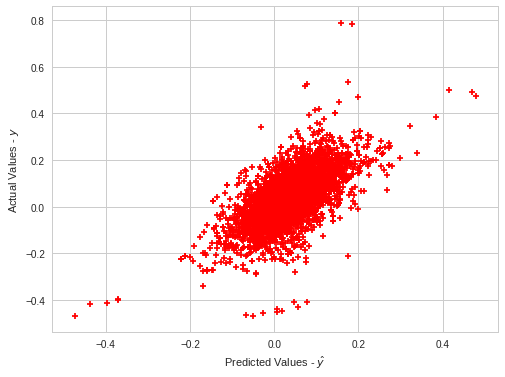

MSE: 0.0053796181298


In [41]:
# Note the difference in argument order
# optionally, you can chain "fit()" to the model object
model = sm.OLS(y, X)
model = model.fit()
predictions = model.predict(X)

# Plot the model
plt.figure(figsize=(8,6))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

print "MSE:", mean_squared_error(y, predictions)

In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            9 week gain   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     146.9
Date:                Thu, 22 Jun 2017   Prob (F-statistic):               0.00
Time:                        18:44:50   Log-Likelihood:                 6832.3
No. Observations:                5724   AIC:                        -1.361e+04
Df Residuals:                    5696   BIC:                        -1.342e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
2 week gain          0.1264      0.028      4.501      0.000       0.071       0.181
4 week gain          0.8026      0.020     40.668      0.000       0.764       0.841
adj_close           -0.0242      0.036     -0.676      0.499      -0.094       0.046
adj_high            -0.0158      0.039     -0.403      0.687      -0.093       0.061
adj_low              0.0117      0.040      0.292      0.771      -0.067       0.091
adj_open             0.0297      0.037      0.812      0.417      -0.042       0.101
adj_volume        2.714e-09   2.28e-09      1.193      0.233   -1.75e-09    7.17e-09
close               -1.0939      1.816     -0.602      0.547      -4.654       2.466
close_12_ema        -0.1053      0.174     -0.607      0.544      -0.446       0.235
close_26_ema         0.1056      0.174      0.608      0.543      -0.235       0.446
cr                2.793e-05   9.29e-05      0.301      0.764      -0.000       0.000
daily_change         1.5776      2.569      0.614      0.539      -3.459       6.614
dailyrate           -0.0994      0.141     -0.704      0.481      -0.376       0.177
derivative       -7.075e-06      0.000     -0.058      0.954      -0.000       0.000
ex-dividend          0.0246      0.021      1.172      0.241      -0.017       0.066
high                 0.4709      0.755      0.624      0.533      -1.008       1.950
low                  0.4445      0.754      0.589      0.556      -1.034       1.923
macd                 0.0584      0.096      0.606      0.545      -0.131       0.248
macdh                0.0231      0.039      0.598      0.550      -0.053       0.099
macds                0.0468      0.077      0.607      0.544      -0.104       0.198
marketclose        -89.2988    147.059     -0.607      0.544    -377.590     198.992
marketgain          89.2988    147.059      0.607      0.544    -198.992     377.590
marketopen          89.2988    147.059      0.607      0.544    -198.992     377.590
middle              -1.3696      2.260     -0.606      0.545      -5.801       3.062
open                 1.0313      1.713      0.602      0.547      -2.327       4.389
open_-2_r            0.0004      0.001      0.647      0.518      -0.001       0.002
open_2_d             0.5160      0.856      0.603      0.547      -1.163       2.195
open_2_s             0.5151      0.856      0.601      0.548      -1.164       2.194
sdf74821084      -4.603e-06      0.000     -0.033      0.974      -0.000       0.000
sdf74821084_-3_s -2.554e-05   7.34e-05     -0.348      0.728      -0.000       0.000
split_ratio          0.0371      0.005      7.209      0.000       0.027       0.047
volatility           0.2049      0.154      1.327      0.185      -0.098       0.507
volume           -2.189e-09   2.29e-09     -0.955      0.340   -6.68e-09     2.3e-09
volume_delta      2.265

In [ ]:
X = medical.drop(['9 week gain','ticker','63 day price','date', 'Category: All categories'], 1)
y = medical['9 week gain']
reg_scores = cross_val_score(LinearRegression(), X, y, cv=10)
print reg_scores, np.mean(reg_scores)

In [44]:
rf = RandomForestRegressor()
rf.fit(X, y)
names = X.dtypes.index
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.4423, '4 week gain'), (0.0365, 'macdh'), (0.0363, '2 week gain'), (0.0337, 'open_-2_r'), (0.0287, 'open_2_d'), (0.0284, 'marketopen'), (0.0283, 'volatility'), (0.0281, 'volume_delta'), (0.0277, 'macds'), (0.0268, 'macd'), (0.0253, 'derivative'), (0.0239, 'marketclose'), (0.023, 'cr'), (0.0217, 'sdf74821084_-3_s'), (0.0213, 'daily_change'), (0.021, 'dailyrate'), (0.0199, 'sdf74821084'), (0.0164, 'volume'), (0.0163, 'marketgain'), (0.0153, 'adj_volume'), (0.0079, 'close_26_ema'), (0.0077, 'adj_open'), (0.0076, 'adj_close'), (0.0074, 'open_2_s'), (0.0069, '14 day price'), (0.0054, 'adj_low'), (0.0051, 'high'), (0.005, '28 day price'), (0.0044, 'open'), (0.0044, 'low'), (0.0043, 'middle'), (0.0043, 'adj_high'), (0.0042, 'close'), (0.004, 'close_12_ema'), (0.0001, 'ex-dividend'), (0.0, 'split_ratio')]


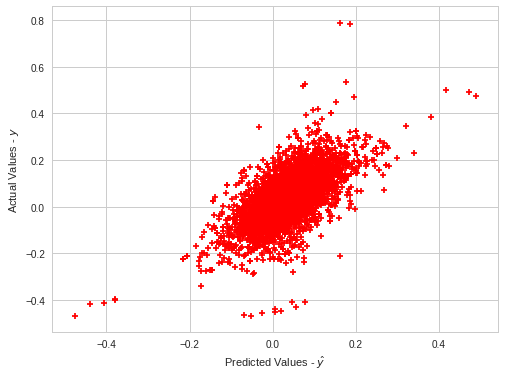

MSE: 0.00537760269045


In [45]:
# Note the difference in argument order
# optionally, you can chain "fit()" to the model object
model = sm.OLS(y, X)
model = model.fit()
predictions = model.predict(X)

# Plot the model
plt.figure(figsize=(8,6))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

print "MSE:", mean_squared_error(y, predictions)

In [46]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            9 week gain   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     136.9
Date:                Thu, 22 Jun 2017   Prob (F-statistic):               0.00
Time:                        18:44:51   Log-Likelihood:                 6833.4
No. Observations:                5724   AIC:                        -1.361e+04
Df Residuals:                    5694   BIC:                        -1.341e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
14 day price         0.0001      0.000      0.627      0.530      -0.000       0.001
2 week gain          0.1062      0.042      2.513      0.012       0.023       0.189
28 day price        -0.0002      0.000     -1.419      0.156      -0.001     8.8e-05
4 week gain          0.8349      0.030     27.618      0.000       0.776       0.894
adj_close           -0.0255      0.036     -0.712      0.476      -0.096       0.045
adj_high            -0.0144      0.039     -0.366      0.714      -0.091       0.063
adj_low              0.0122      0.040      0.304      0.761      -0.067       0.091
adj_open             0.0291      0.037      0.794      0.427      -0.043       0.101
adj_volume        2.686e-09   2.28e-09      1.180      0.238   -1.78e-09    7.15e-09
close                0.0126      0.030      0.420      0.675      -0.046       0.071
close_12_ema         0.0117      0.019      0.627      0.531      -0.025       0.048
close_26_ema        -0.0115      0.019     -0.615      0.539      -0.048       0.025
cr                2.327e-05   9.33e-05      0.249      0.803      -0.000       0.000
daily_change         0.0154      0.013      1.183      0.237      -0.010       0.041
dailyrate           -0.1160      0.143     -0.811      0.418      -0.396       0.164
derivative       -8.053e-06      0.000     -0.066      0.947      -0.000       0.000
ex-dividend          0.0247      0.021      1.177      0.239      -0.016       0.066
high                 0.0124      0.037      0.334      0.738      -0.060       0.085
low                 -0.0131      0.038     -0.346      0.730      -0.087       0.061
macd                -0.0067      0.010     -0.644      0.520      -0.027       0.014
macdh               -0.0030      0.004     -0.705      0.481      -0.011       0.005
macds               -0.0052      0.008     -0.625      0.532      -0.021       0.011
marketclose        -92.0738    147.055     -0.626      0.531    -380.358     196.210
marketgain          92.0738    147.055      0.626      0.531    -196.210     380.358
marketopen          92.0738    147.055      0.626      0.531    -196.210     380.358
middle               0.0018      0.009      0.192      0.848      -0.017       0.020
open                -0.0099      0.025     -0.398      0.690      -0.058       0.039
open_-2_r            0.0004      0.001      0.660      0.509      -0.001       0.002
open_2_d            -0.0045      0.012     -0.361      0.718      -0.029       0.020
open_2_s            -0.0054      0.012     -0.436      0.663      -0.030       0.019
sdf74821084       5.307e-06      0.000      0.038      0.970      -0.000       0.000
sdf74821084_-3_s -2.994e-05   7.36e-05     -0.407      0.684      -0.000       0.000
split_ratio          0.0367      0.005      7.110      0.000       0.027       0.047
volatility           0.

In [47]:
X = medical[['4 week gain','open_-2_r','marketopen']]
y = medical['9 week gain']
reg_scores = cross_val_score(LinearRegression(), X, y, cv=4)
print reg_scores, np.mean(reg_scores)

[ 0.38352669  0.40886792  0.37258305  0.39185547] 0.389208281706


In [48]:
rf = RandomForestRegressor()
rf.fit(X, y)
names = X.dtypes.index
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

Features sorted by their score:
[(0.5954, '4 week gain'), (0.2129, 'marketopen'), (0.1917, 'open_-2_r')]


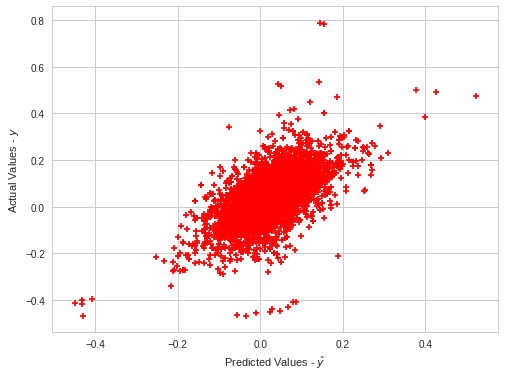

MSE: 0.00591903747375


In [49]:
# Note the difference in argument order
# optionally, you can chain "fit()" to the model object
model = sm.OLS(y, X)
model = model.fit()
predictions = model.predict(X)

# Plot the model
plt.figure(figsize=(8,6))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.show()

print "MSE:", mean_squared_error(y, predictions)

In [50]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            9 week gain   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     1452.
Date:                Thu, 22 Jun 2017   Prob (F-statistic):               0.00
Time:                        18:44:52   Log-Likelihood:                 6558.9
No. Observations:                5724   AIC:                        -1.311e+04
Df Residuals:                    5721   BIC:                        -1.309e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
4 week gain     0.9427      0.015     63.825      0.000       0.914       0.972
open_-2_r       0.0009      0.000      2.050      0.040    3.84e-05       0.002
marketopen   1.836e-11   1.88e-12      9.743      0.000    1.47e-11    2.21e-11
==============================================================================
Omnibus:                      680.083   Durbin-Watson:                   0.526
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7148.824
Skew:                          -0.026   Prob(JB):                         0.00
Kurtosis:                       8.475   Cond. No.                     7.88e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.88e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=8)

lr = LinearRegression()

lr.fit(X_train, y_train)

lr.score(X_test, y_test)


0.40893789085741211

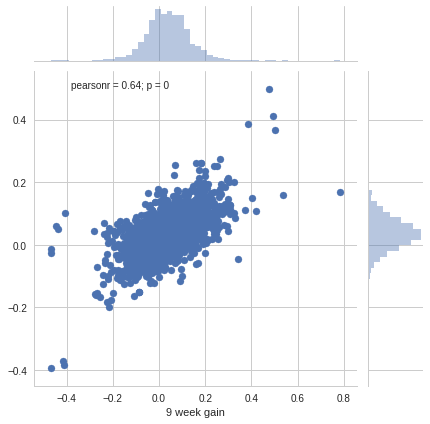

In [52]:
yhat = lr.predict(X_test)
sns.jointplot(y_test, yhat)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=8)

lr2 = LinearRegression()

lr2.fit(X_train,y_train)

lr2.score(X_test, y_test)

0.40344556510264118

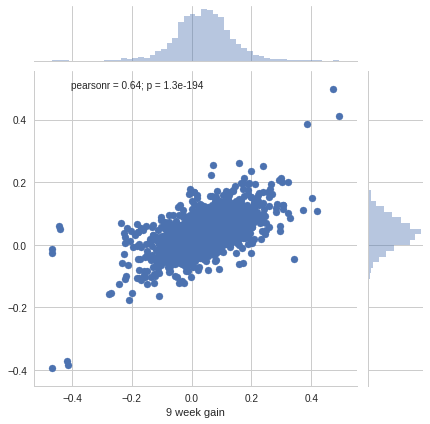

In [ ]:
yhat = lr.predict(X_test)
sns.jointplot(y_test, yhat)

In [ ]:
sns.pairplot(medical, size= 10)

In [ ]:
medical.corr()